# State Machines in Python - Part 2

In this part, we have a closer look at a (simple) user interface to control our state machine, and discover more features of STMPY.

In [ ]:
from stmpy import Machine, Driver

import ipywidgets as widgets
from IPython.display import display

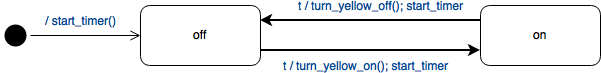

## Signal Light

We create a blinking light. As basis, we use the code below that offers a simple user interface in Python Notebooks. 

Have a look at the class below. It displays an image and two buttons. In addition, it prepares the action we need for the state machine.

In [ ]:
class SignalLight:
    
    def on_button_switch(self, b):
        self.stm.send('switch') # <---- here we send a signal
        
    def on_button_terminate(self, b):
        self.stm.driver.stop() # <---- here we stop the driver
    
    def __init__(self):
        # load images and store them
        self.yellow_on = open("images/yellow_on.png", "rb").read()
        self.yellow_off = open("images/yellow_off.png", "rb").read()
        
        # display the user interface
        # a button
        self.button_switch = widgets.Button(description="Send 'switch'")
        self.button_switch.on_click(self.on_button_switch)
        # another button
        self.button_terminate = widgets.Button(description="Stop the Driver")
        self.button_terminate.on_click(self.on_button_terminate)
        # an image of a yellow light
        self.yellow = widgets.Image(value=self.yellow_off, format='png', width=50, height=50)
        # display everything
        display(self.yellow, self.button_switch, self.button_terminate)
        
    def turn_yellow_on(self):
        # switch on the yellow light
        self.yellow.set_trait(name='value', value=self.yellow_on)
        
    def turn_yellow_off(self):
        # switch off the yellow light
        self.yellow.set_trait(name='value', value=self.yellow_off)

We declare the state machine using three transitions. As you can see, the effects on the transitions can refer to several methods, separated with a `;`.

Run the cell below. You should see a blinking light. It stops when you click on the `Stop the Driver` button. To restart it, just run the cell again.

In [ ]:
signal = SignalLight()

t0 = {'source': 'initial',
      'effect': 'start_timer("t", 1000)',
      'target': 'off'}
t1 = {'trigger':'t',
      'source':'off',
      'target':'on',
      'effect':'turn_yellow_on; start_timer("t", 1000)'}
t2 = {'trigger':'t', 
      'source':'on', 
      'target':'off', 
      'effect':'turn_yellow_off; start_timer("t", 1000)'}

machine = Machine(name='signal', transitions=[t0, t1, t2], obj=signal)
signal.stm = machine

driver = Driver()
driver.add_machine(machine)
driver.start()

## Sending Messages

So far, the state machines were controlled by timers. We can also trigger the state machine by messages. The messages can come from different sources --- hardware, software interrrupts, incoming communication packages, or, as here, clicks on a user interfaces.

The button `Send Message switch` was not yet used in the example. Have a look again at the SignalLight class. When this button is pressed, a message `switch` is sent to the state machine. (Actually, its driver.) We can usew this message to trigger the transition, so we have a manual signal light.

Execute the cell below. Nothing should happen, until you press the button `Send 'switch'`.

In [ ]:
signal_2 = SignalLight()

t0 = {'source': 'initial',
      'target': 'off'}
t1 = {'trigger':'switch',
      'source':'off',
      'target':'on',
      'effect':'turn_yellow_on'}
t2 = {'trigger':'switch', 
      'source':'on', 
      'target':'off', 
      'effect':'turn_yellow_off'}

machine_2 = Machine(name='signal_2', transitions=[t0, t1, t2], obj=signal_2)
signal_2.stm = machine_2

driver_2 = Driver()
driver_2.add_machine(machine_2)
driver_2.start()

If you press the `Stop the Driver` button, the driver will stop and your signals will not be forwarded to the state machine anymore. Restart the cell to start over again.